In [1]:
import torch
import os
import csv
import math
import random
import numpy as np
from itertools import permutations

In [2]:
import sys
import os
from importlib import reload
here = os.getcwd()
sys.path.append(os.path.join(here,"../"))

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from models.cde.cde_data_common import process_data,get_final_linear_input_channels,get_final_indices,wrap_data,augment_data
import models.cde.cde_train_common as train_common
import models.cde.cde_data_common as cde_data_common
import explainer.rule_pattern_miner as rlm
import explainer.explainer_utils as eutils

from utils.test_utils import make_results_filenames

#from explainer.integrad import integrad
from explainer.FPGrowth_tree import *
from explainer.rule_pattern_miner import *
from explainer.explainer_utils import *
import explainer.RuleGrowth_tree as rgtree

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,confusion_matrix,precision_score,recall_score,accuracy_score,roc_auc_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt 
import seaborn as sns

In [5]:
import explainer.explainer_utils as eutils
import models.cde as cde

In [6]:
def new_make_model():
    model, regularise = make_model()
    model.linear.weight.register_hook(lambda grad: 100 * grad)
    model.linear.bias.register_hook(lambda grad: 100 * grad)
    return model, regularise

In [7]:
def group_processed_data(X,y,times):
    X = torch.tensor(X)
    y = torch.tensor(y)
    final_indices,_ = get_final_indices(times,y)
    coeffs = process_data(times,X,intensity=args.intensity,time_intensity=args.time_intensity,cummean=cummean,cumsum=cumsum,append_times=args.append_times,interpolate=args.interpolate)
    return coeffs,y,final_indices

In [8]:
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--dpath',default='../data', help='Path to data file')
parser.add_argument('--rpath',default='./results', help='Path to save results')
parser.add_argument('--use_phys',action='store_true', help='Use physiology data or not')
parser.add_argument('--seed',default=0,type=int, help='Random seed')
parser.add_argument('--model_name',default='ncde',type=str, help='Model name')
parser.add_argument('--interpolate',default='cubic_spline',type=str, help='Interpolation function name')
parser.add_argument('--device',default='cpu',type=str, help='cpu or cuda')
parser.add_argument('--side_input',action='store_true', help='Use side input to final task')
parser.add_argument('--concat_z',action='store_true', help='Concat hidden states for the final task')
parser.add_argument('--time_intensity',action='store_true', help='Add time intensity')
parser.add_argument('--append_times',action='store_true', help='Append time indices as one feature')
parser.add_argument('--intensity',action='store_true', help='Add X intensity')
parser.add_argument('--time_len',default=12,type=int, help='Length of time indices')
parser.add_argument('--hidden_channels',default=2,type=int, help='Dimension of hidden states z')
parser.add_argument('--hidden_hidden_channels',default=128,type=int, help='Dimension of hidden units of f')
parser.add_argument('--num_hidden_layers',default=4,type=int, help='Number of hidden layers of f')
parser.add_argument('--batch_size',default=1024,type=int, help='Batch size')
parser.add_argument('--max_epochs',default=500,type=int, help='Maximum epochs')
parser.add_argument('--pos_weight',default=20,type=int, help='Weight of positive class')
parser.add_argument('--lr',default=0.0001,type=float, help='Raw learning rate')
parser.add_argument('--K',default=5,type=int, help='K-fold cross-validation')

args,_ = parser.parse_known_args()

#print(args)




model_name=args.model_name 
#device=args.device
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

    
args.interpolate = "linear"    
args.side_input = False
args.concat_z = True

args.append_times = False
args.time_intensity = True
args.intensity = True 

args.time_len = 72
args.max_epochs = 100
args.pos_weight = 20

hidden_channels=args.hidden_channels 
hidden_hidden_channels=args.hidden_hidden_channels 
num_hidden_layers=args.num_hidden_layers

batch_size = args.batch_size

lr = args.lr * (batch_size / 64)


dpath = args.dpath
use_phys = args.use_phys
concat_z = args.concat_z
seed = args.seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

name = make_results_filenames(args,'sepsis')

num_classes = 2
cummean = True
cumsum = False

In [9]:
pp = "/Users/chenyu/github/NDE-Models-DigitalHealth/"

In [10]:
base_loc = pp+'data/raw/sepsis/'
static_intensity = True
time_intensity = True

In [11]:
X_times = []
X_static = []
y = []
H = args.time_len
for filename in os.listdir(base_loc):
    if filename.endswith('.psv'):
        with open(os.path.join(base_loc,filename)) as file:
            time = []
            label = 0.0
            reader = csv.reader(file, delimiter='|')
            reader = iter(reader)
            next(reader)  # first line is headings
            prev_iculos = 0
            for line in reader:
                assert len(line) == 41
                # time values are 34 features
                *time_values, age, gender, unit1, unit2, hospadmtime, iculos, sepsislabel = line
                iculos = int(iculos)
                #print('iculos',iculos)
                if iculos > H:  # keep at most the first H hours
                    break
                ## padding nan for missing hours
                for iculos_ in range(prev_iculos + 1, iculos):
                    time.append([float('nan') for value in time_values])
                    #time.append(np.zeros(len(time_values))+np.nan)
                prev_iculos = iculos
                time.append([float(value) for value in time_values])
                label = max(label, float(sepsislabel))
            unit1 = float(unit1)
            unit2 = float(unit2)
            unit1_obs = not math.isnan(unit1)
            unit2_obs = not math.isnan(unit2)
            if not unit1_obs:
                unit1 = 0.
            if not unit2_obs:
                unit2 = 0.
            hospadmtime = float(hospadmtime)
            if math.isnan(hospadmtime):
                hospadmtime = 0.  # this only happens for one record
            static = [float(age), float(gender), unit1, unit2, hospadmtime]
            if static_intensity:
                static += [unit1_obs, unit2_obs]
            if len(time) > 2:
                if len(time) < H:
                    # padding less hours
                    for t in range(H-len(time)):
                        time.append([float('nan') for value in time_values])
                X_times.append(time)
                X_static.append(static)
                y.append(label)
    

In [12]:
len(X_times[0])

72

In [13]:
times = np.arange(args.time_len).astype(np.float32)
times = torch.tensor(times)

In [14]:
X_times = np.array(X_times)
X_static = np.array(X_static)
y = np.array(y)

In [15]:
X_times = X_times.astype(np.float32)
y = y.astype(np.float32)

In [16]:
X_times.shape,X_static.shape,y.shape

((40333, 72, 34), (40333, 7), (40333,))

In [17]:
X_train,X_test,y_train,y_test = train_test_split(X_times,y,test_size=0.2,random_state=args.seed)
X_test,X_val,y_test,y_val = train_test_split(X_test,y_test,test_size=0.5,random_state=args.seed)

In [18]:
for c in range(X_times.shape[-1]):
    mi = X_train[:,:,c][~np.isnan(X_train[:,:,c])].min()
    ma = X_train[:,:,c][~np.isnan(X_train[:,:,c])].max()
    X_train[:,:,c] = (X_train[:,:,c] - mi)/(ma - mi)+1.
    X_test[:,:,c] = (X_test[:,:,c] - mi)/(ma - mi)+1.
    X_val[:,:,c] = (X_val[:,:,c] - mi)/(ma - mi)+1.
#     X_times[:,:,c][np.isnan(X_times[:,:,c])] = 0.  # fill in missing value

In [19]:
X_train.shape,X_test.shape,X_val.shape

((32266, 72, 34), (4033, 72, 34), (4034, 72, 34))

In [20]:
y_train.sum(),y_test.sum(),y_val.sum()

(1741.0, 225.0, 222.0)

In [21]:
(y_train==1).sum()/len(y_train),(y_test==1).sum()/len(y_test)

(0.05395772639930577, 0.05578973468881726)

In [22]:
X_train_raw = augment_data(torch.tensor(X_train),times,intensity=args.intensity,time_intensity=args.time_intensity,cummean=cummean,cumsum=cumsum,append_times=args.append_times)
X_test_raw = augment_data(torch.tensor(X_test),times,intensity=args.intensity,time_intensity=args.time_intensity,cummean=cummean,cumsum=cumsum,append_times=args.append_times)
X_val_raw = augment_data(torch.tensor(X_val),times,intensity=args.intensity,time_intensity=args.time_intensity,cummean=cummean,cumsum=cumsum,append_times=args.append_times)

In [23]:
train_data = group_processed_data(X_train,y_train,times)
test_data = group_processed_data(X_test,y_test,times)
val_data = group_processed_data(X_val,y_val,times)

check X torch.Size([32266, 72, 136])
check X torch.Size([4033, 72, 136])
check X torch.Size([4034, 72, 136])


In [24]:
input_channels = train_data[0][0].shape[-1]
output_channels = 1
stream = True if concat_z else False
input_channels

136

In [25]:
if concat_z or side_input:
    side_input_dim = cv_sets[0][0][-1].shape[-1] if args.side_input else 0
    final_linear_input_channels = get_final_linear_input_channels(hidden_channels,side_input_dim=side_input_dim,time_len=args.time_len)
else:
    final_linear_input_channels = None

In [26]:
make_model = train_common.make_model(model_name, input_channels, output_channels, hidden_channels,
                               hidden_hidden_channels, num_hidden_layers, use_intensity=False,
                              final_linear_input_channels=final_linear_input_channels, 
                              initial=True,side_input=args.side_input,append_times=args.append_times,interpolate=args.interpolate)


In [27]:
### uncomment this cell if need to train a new model
# times, train_dataloader, val_dataloader, test_dataloader = wrap_data(times, train_data, val_data, test_data, device,
#                                                                                     batch_size=batch_size,num_workers=0)

# log,log_num = train_common.main(name, times, train_dataloader, val_dataloader, test_dataloader, device,
#                    new_make_model, num_classes, args.max_epochs, lr, kwargs={'stream':stream}, pos_weight=torch.tensor(args.pos_weight),
#                    step_mode=True,rpath=args.rpath)

In [27]:
raw_feature_names = ['HR','O2Sat','Temp','SBP','MAP','DBP','Resp','EtCO2','BaseExcess','HCO3','FiO2','pH','PaCO2','SaO2',
                    'AST','BUN','Alkalinephos','Calcium','Chloride','Creatinine','Bilirubin_direct','Glucose','Lactate','Magnesium',
                    'Phosphate','Potassium','Bilirubin_total','TroponinI','Hct','Hgb','PTT','WBC','Fibrinogen','Platelets']

In [28]:
latent_feature_names = [r'$z_'+str(i)+'(t_{'+str(h)+'})$' for h in range(args.time_len) for i in range(hidden_channels) ]
intensity_feature_names = [rf+'_ctime' for rf in raw_feature_names] + [rf+'_cmax' for rf in raw_feature_names] + [rf+'_cmean' for rf in raw_feature_names] 
input_feature_names = raw_feature_names + intensity_feature_names
feature_types = ["int" if "ctime" in fn else "float" for fn in input_feature_names] 
len(input_feature_names)

136

In [29]:
## load model
#args.model_path = pp+"xncde/notebooks/results/sepsis/intensity_time_intensity_concatz/zdim2_hdim128_nlayer4_bs1024/posw20/interp_cubic_spline/model_2"
args.model_path = "./results/sepsis/intensity_time_intensity_concatz/zdim2_hdim128_nlayer4_bs1024/posw20/interp_linear/model_6"
model, regularise_parameters = make_model()
model.load_state_dict(torch.load(args.model_path))
model.to('cpu')
model.eval()

interpolate linear


NeuralCDE(
  input_channels=136, hidden_channels=2, output_channels=1, initial=True
  (func): FinalTanh(
    input_channels: 136, hidden_channels: 2, hidden_hidden_channels: 128, num_hidden_layers: 4
    (linear_in): Linear(in_features=2, out_features=128, bias=True)
    (linears): ModuleList(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=128, bias=True)
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
    (linear_out): Linear(in_features=128, out_features=272, bias=True)
  )
  (initial_network): Linear(in_features=136, out_features=2, bias=True)
  (linear): Linear(in_features=144, out_features=1, bias=True)
)

In [30]:
model.append_times=args.append_times
train_reps = model.latent_representation(X_train_raw,times=times).detach()
test_reps = model.latent_representation(X_test_raw,times=times).detach()
val_reps = model.latent_representation(X_val_raw,times=times).detach()

In [31]:
baselines = gen_intgrad_baselines(X_train_raw,y_train,train_reps)
subset = gen_balanced_subset(X_train_raw,y_train,size_per_class=int(y_train.sum()))

In [33]:
reload(eutils)

<module 'explainer.explainer_utils' from '/Users/chenyu/github/INSPIRE/code/notebooks/../explainer/explainer_utils.py'>

In [32]:
### for binary classfication with 1d output, 
### the two classes share one dimension, 
### so needs to specify the target class explicitly
int_g, z_shift = [], []
for c in range(2):
    int_g_c, z_shift_c = eutils.calc_baselines_intg(test_examples=subset,model=model,baselines=baselines,times=times,target_c=c,target_dim=0,C=2)
    int_g.append(int_g_c)
    z_shift.append(z_shift_c)

int_g = torch.vstack(int_g)
z_shift = torch.vstack(z_shift)

In [33]:
z_shift.shape,int_g.shape

(torch.Size([3482, 72, 2]), torch.Size([3482, 72, 2, 136]))

In [34]:
linear_prams = []
for p in model.linear.parameters():
    p = p.detach()
    print(p.shape,p)
    linear_prams.append(p)

torch.Size([1, 144]) tensor([[ 1.0704e+00,  8.5765e-02,  1.1769e-01,  1.0329e-01, -3.7675e-02,
         -1.2997e-02,  2.9618e-02,  1.0850e-01,  1.5762e-01,  1.1487e-01,
          8.3647e-02, -7.8373e-02,  3.8490e-02, -1.6602e-01, -7.2165e-02,
         -2.0518e-01,  1.4428e-02, -1.0672e-01,  1.3788e-03,  3.2502e-02,
          1.5803e-02,  7.3149e-02,  2.4017e-02,  1.2093e-01,  6.5058e-02,
          1.2605e-01,  8.3611e-02,  4.3516e-02,  4.1736e-02, -3.1353e-02,
          1.3206e-01,  2.1234e-02,  1.1338e-01, -1.0024e-01,  7.7826e-02,
         -2.5844e-02,  1.1019e-01, -9.2667e-02,  4.3463e-02, -1.0907e-01,
          9.0599e-02,  1.4591e-02,  6.3200e-02, -9.2351e-02, -5.6002e-02,
         -3.8373e-02, -1.5101e-02, -4.2670e-03,  1.9668e-02,  9.7773e-03,
          5.2734e-02, -2.5556e-02,  1.0957e-03, -4.2817e-02,  4.5200e-02,
         -6.9716e-02,  1.0085e-02,  1.0093e-02, -5.4824e-02,  5.5321e-02,
         -4.5983e-02, -3.0803e-02,  4.7941e-02,  5.7862e-02, -7.3943e-02,
         -3.0601e

In [35]:
pred_y_train = (torch.matmul(train_reps.reshape(train_reps.shape[0],-1),linear_prams[0].transpose(1,0))+linear_prams[1]).numpy().reshape(-1)
pred_y_test = (torch.matmul(test_reps.reshape(test_reps.shape[0],-1),linear_prams[0].transpose(1,0))+linear_prams[1]).numpy().reshape(-1)
pred_y_val = (torch.matmul(val_reps.reshape(val_reps.shape[0],-1),linear_prams[0].transpose(1,0))+linear_prams[1]).numpy().reshape(-1)

y threshold 0.5603482


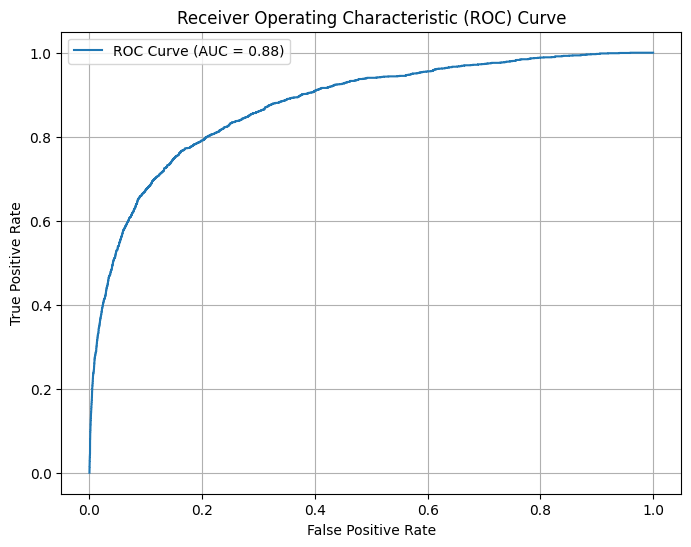

In [36]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import scipy as sp

pred_y = sp.special.expit(pred_y_train)
auc = roc_auc_score(y_train, pred_y)
fpr, tpr, thresholds = roc_curve(y_train, pred_y)
y_thd = thresholds[np.argmax(tpr - fpr)]
print("y threshold",y_thd)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.show()

In [37]:
(pred_y>y_thd).sum(),recall_score(y_train,pred_y>y_thd),precision_score(y_train,pred_y>y_thd)

(6299, 0.7656519241815049, 0.21162089220511193)

In [38]:
C=2
baseline_reps = model.latent_representation(baselines,times=times)
baseline_output = model.linear(baseline_reps.reshape(baseline_reps.shape[0],-1)).detach()

subset_reps,subset_output = [],[]
for k in range(C):
    subset_reps.append(model.latent_representation(subset[k],times=times))
    subset_output.append(model.linear(subset_reps[k].reshape(subset_reps[k].shape[0],-1)).detach())

In [39]:
cids = np.arange(C)
yshift = []
for k in cids:
    for kk in cids[cids!=k]:
        yshift.append(subset_output[k]-baseline_output[kk])
yshift = torch.vstack(yshift)

In [40]:
weights = linear_prams[0].reshape(-1,args.hidden_channels)
y_int_g = output_intg_score(int_g,weights,yshift)
y_int_g[torch.isnan(y_int_g)] = 0.

In [272]:
thds = np.linspace(0.01,0.2,200)
f_n = []
for thd in thds:
    mask = torch.abs(y_int_g) >= thd 
    f_n.append((thd,(mask.sum(dim=0)>=len(y_int_g)*0.99).sum()))
    print(f_n[-1])
    if f_n[-1][1]==1:
        break
thd = f_n[-1][0]
thd

(0.01, tensor(55))
(0.010954773869346734, tensor(46))
(0.011909547738693467, tensor(38))
(0.012864321608040201, tensor(32))
(0.013819095477386936, tensor(25))
(0.014773869346733668, tensor(22))
(0.015728643216080404, tensor(21))
(0.016683417085427137, tensor(15))
(0.01763819095477387, tensor(11))
(0.0185929648241206, tensor(8))
(0.019547738693467338, tensor(8))
(0.020502512562814074, tensor(1))


0.020502512562814074

Text(0, 0.5, 'Log number of features with max frequecy')

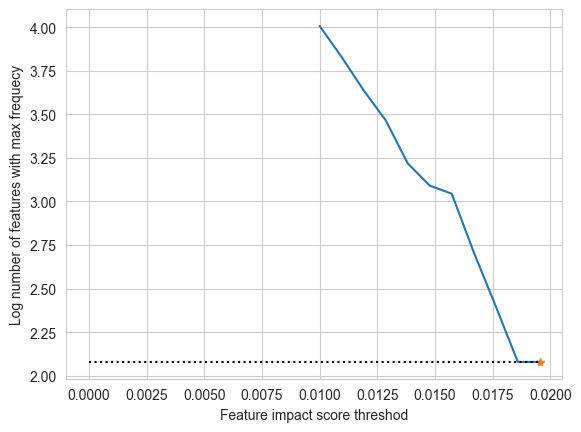

In [273]:
import seaborn as sns
sns.set_style("whitegrid")
plt.plot([th[0] for th in f_n[:-1]],[np.log(th[1].numpy()) for th in f_n[:-1]])
plt.plot(f_n[-2][0],np.log(f_n[-2][1].numpy()),"*")
plt.plot([0,f_n[-2][0]],[np.log(f_n[-2][1].numpy()),np.log(f_n[-2][1].numpy())],":k")
#plt.xlim(0.01,0.04)
#plt.ylim(0.,750)
plt.xlabel("Feature impact score threshod")
plt.ylabel("Log number of features with max frequecy")
#plt.savefig("./results/sepsis/scan_thd_demo.eps",bbox_inches="tight")

In [300]:
itemsets_y = transform_intgrad_to_itemsets(y_int_g,thd=thd,K=1)
fids = gen_freq_feature_set(itemsets_y[0],min_support=100,max_len=500)
fids = np.array(fids).astype(int)-1
print('feature set',fids,len(fids))

[7655.0] 3449.0
[7655.0, 5071.0] 3414.0
[7655.0, 5071.0, 9151.0] 3399.0
[7655.0, 5071.0, 9151.0, 9691.0] 3382.0
[7655.0, 5071.0, 9151.0, 9691.0, 6703.0] 3365.0
[7655.0, 5071.0, 9151.0, 9691.0, 6703.0, 8335.0] 3354.0
[7655.0, 5071.0, 9151.0, 9691.0, 6703.0, 8335.0, 9420.0] 3346.0
[7655.0, 5071.0, 9151.0, 9691.0, 6703.0, 8335.0, 9420.0, 9423.0] 3342.0
[7655.0, 5071.0, 9151.0, 9691.0, 6703.0, 8335.0, 9420.0, 9423.0, 9425.0] 3329.0
[7655.0, 5071.0, 9151.0, 9691.0, 6703.0, 8335.0, 9420.0, 9423.0, 9425.0, 7657.0] 3315.0
[7655.0, 5071.0, 9151.0, 9691.0, 6703.0, 8335.0, 9420.0, 9423.0, 9425.0, 7657.0, 6019.0] 3305.0
[7655.0, 5071.0, 9151.0, 9691.0, 6703.0, 8335.0, 9420.0, 9423.0, 9425.0, 7657.0, 6019.0, 9419.0] 3302.0
[7655.0, 5071.0, 9151.0, 9691.0, 6703.0, 8335.0, 9420.0, 9423.0, 9425.0, 7657.0, 6019.0, 9419.0, 9559.0] 3297.0
[7655.0, 5071.0, 9151.0, 9691.0, 6703.0, 8335.0, 9420.0, 9423.0, 9425.0, 7657.0, 6019.0, 9419.0, 9559.0, 9692.0] 3293.0
[7655.0, 5071.0, 9151.0, 9691.0, 6703.0, 8335.0,

In [275]:
# sns.set_style("white")
# cmap = sns.color_palette("colorblind")
# fig, ax1 = plt.subplots()
# sns.histplot(pred_y[y_train==0],kde=True,ax=ax1,bins=50,color=cmap[0],label="No Sepsis")
# ax2 = ax1.twinx()
# sns.histplot(pred_y[y_train==1],kde=True,ax=ax2,bins=50,color=cmap[1],label="Sepsis")
# ax1.set_xlabel(r"$\hat{y}$")
# ax1.legend(loc='upper left', bbox_to_anchor=(0.15, 1.))
# ax2.legend(loc='upper right', bbox_to_anchor=(0.9, 1.))
# #plt.savefig("./results/sepsis/pred_y_hist.svg",bbox_inches="tight")

In [276]:
len(y_train), (y_train==1).sum(),((y_train==1).sum()/len(y_train)),((pred_y>y_thd).sum()/len(pred_y)),((pred_y<=y_thd).sum()/len(pred_y))

(32266, 1741, 0.05395772639930577, 0.19522097563999255, 0.8047790243600075)

In [357]:
reload(rlm)

<module 'explainer.rule_pattern_miner' from '/Users/chenyu/github/INSPIRE/code/notebooks/../explainer/rule_pattern_miner.py'>

In [358]:
min_support=1000
num_grids=5
max_depth=3

x = X_train_raw.reshape(X_train_raw.shape[0],-1).numpy()
y_rule_candidates = rlm.gen_rule_list_for_one_target(x,fids,pred_y>y_thd,y=y_train,c=1,sort_by="cond_prob_target",
                                                    min_support=min_support,num_grids=num_grids,max_depth=max_depth,top_K=3,
                                                    local_x=None,feature_types=feature_types*args.time_len,
                                                    verbose=False,search="greedy")

build_rule_tree
init rule tree
search rule for feature 7654
search rule for feature 5070
search rule for feature 9150
search rule for feature 9690
search rule for feature 6702
search rule for feature 8334
search rule for feature 9419
search rule for feature 9422
search rule for feature 9424
search rule for feature 7656
search rule for feature 6018
search rule for feature 9418
search rule for feature 9558
search rule for feature 9691
search rule for feature 9696
search rule for feature 8469
search rule for feature 9421
search rule for feature 8330
search rule for feature 4662
search rule for feature 8333
search rule for feature 9013
search rule for feature 8331
search rule for feature 9693
search rule for feature 6021
search rule for feature 7651
search rule for feature 9016
search rule for feature 4934
search rule for feature 6294
search rule for feature 6566
search rule for feature 9560
search rule for feature 8064
search rule for feature 8336
search rule for feature 8466
search rule 

search rule for feature 2349
search rule for feature 7381
search rule for feature 7807
search rule for feature 9031
search rule for feature 8487
search rule for feature 1806
search rule for feature 2346
search rule for feature 2075
search rule for feature 6311
search rule for feature 3032
search rule for feature 2352
search rule for feature 9157
search rule for feature 9284
search rule for feature 2084
search rule for feature 9439
search rule for feature 5339
search rule for feature 2076
search rule for feature 8743
search rule for feature 6703
search rule for feature 8345
search rule for feature 8471
search rule for feature 5892
search rule for feature 6292
search rule for feature 5067
search rule for feature 3444
search rule for feature 3573
search rule for feature 5202
search rule for feature 2077
search rule for feature 8339
search rule for feature 7535
search rule for feature 2892
search rule for feature 6980
search rule for feature 7665
search rule for feature 3026
search rule fo

search rule for feature 4658
search rule for feature 9420
search rule for feature 9146
search rule for feature 4659
search rule for feature 4930
search rule for feature 5747
search rule for feature 6022
search rule for feature 5886
search rule for feature 6293
search rule for feature 5749
search rule for feature 7112
search rule for feature 7109
search rule for feature 7107
search rule for feature 4794
search rule for feature 7786
search rule for feature 7520
search rule for feature 5752
search rule for feature 7515
search rule for feature 9282
search rule for feature 8738
search rule for feature 4936
search rule for feature 6973
search rule for feature 5885
search rule for feature 6290
search rule for feature 4800
search rule for feature 4795
search rule for feature 4386
search rule for feature 9285
search rule for feature 4931
search rule for feature 7518
search rule for feature 7926
search rule for feature 9283
search rule for feature 9012
search rule for feature 9288
search rule fo

search rule for feature 3999
search rule for feature 4117
search rule for feature 6709
search rule for feature 3580
search rule for feature 9159
search rule for feature 9161
search rule for feature 6572
search rule for feature 1676
search rule for feature 8203
search rule for feature 9707
search rule for feature 1941
search rule for feature 6040
search rule for feature 8473
search rule for feature 4667
search rule for feature 7933
search rule for feature 6975
search rule for feature 2487
search rule for feature 2215
search rule for feature 9430
search rule for feature 6176
search rule for feature 9698
search rule for feature 9017
search rule for feature 5476
search rule for feature 5348
search rule for feature 8342
search rule for feature 2895
search rule for feature 5903
search rule for feature 6563
search rule for feature 9168
search rule for feature 4396
search rule for feature 5767
search rule for feature 8360
search rule for feature 6583
search rule for feature 8475
search rule fo

search rule for feature 8608
search rule for feature 6565
search rule for feature 2622
search rule for feature 8744
search rule for feature 2628
search rule for feature 2890
search rule for feature 4389
search rule for feature 3437
search rule for feature 5206
search rule for feature 4525
search rule for feature 8476
search rule for feature 8874
search rule for feature 2900
search rule for feature 6039
search rule for feature 6156
search rule for feature 9020
search rule for feature 2210
search rule for feature 5072
search rule for feature 2488
search rule for feature 6175
search rule for feature 8340
search rule for feature 3707
search rule for feature 6023
search rule for feature 3712
search rule for feature 6159
search rule for feature 2758
search rule for feature 7927
search rule for feature 9156
search rule for feature 3716
search rule for feature 6020
search rule for feature 3988
search rule for feature 7943
search rule for feature 5344
search rule for feature 7244
search rule fo

search rule for feature 7656
search rule for feature 6018
search rule for feature 9418
search rule for feature 9558
search rule for feature 9691
search rule for feature 9696
search rule for feature 8469
search rule for feature 9421
search rule for feature 8330
search rule for feature 4662
search rule for feature 8333
search rule for feature 9013
search rule for feature 8331
search rule for feature 9693
search rule for feature 6021
search rule for feature 7651
search rule for feature 9016
search rule for feature 4934
search rule for feature 6294
search rule for feature 6566
search rule for feature 9560
search rule for feature 8064
search rule for feature 8336
search rule for feature 8466
search rule for feature 6974
search rule for feature 9011
search rule for feature 7653
search rule for feature 8062
search rule for feature 7650
search rule for feature 7925
search rule for feature 9149
search rule for feature 6154
search rule for feature 8467
search rule for feature 9554
search rule fo

search rule for feature 7663
search rule for feature 3436
search rule for feature 3727
search rule for feature 6165
search rule for feature 6029
search rule for feature 4528
search rule for feature 9292
search rule for feature 8073
search rule for feature 1948
search rule for feature 1808
search rule for feature 9567
search rule for feature 9431
search rule for feature 8337
search rule for feature 4804
search rule for feature 3999
search rule for feature 4117
search rule for feature 6709
search rule for feature 3580
search rule for feature 9159
search rule for feature 9161
search rule for feature 6572
search rule for feature 1676
search rule for feature 8203
search rule for feature 9707
search rule for feature 1941
search rule for feature 6040
search rule for feature 8473
search rule for feature 4667
search rule for feature 7933
search rule for feature 6975
search rule for feature 2487
search rule for feature 2215
search rule for feature 9430
search rule for feature 6176
search rule fo

search rule for feature 6156
search rule for feature 9020
search rule for feature 2210
search rule for feature 5072
search rule for feature 2488
search rule for feature 6175
search rule for feature 8340
search rule for feature 3707
search rule for feature 6023
search rule for feature 3712
search rule for feature 6159
search rule for feature 2758
search rule for feature 7927
search rule for feature 9156
search rule for feature 3716
search rule for feature 6020
search rule for feature 3988
search rule for feature 7943
search rule for feature 5344
search rule for feature 7244
search rule for feature 2483
search rule for feature 4114
search rule for feature 6296
search rule for feature 5750
search rule for feature 2754
search rule for feature 5883
search rule for feature 2894
search rule for feature 8603
search rule for feature 2760
search rule for feature 3440
search rule for feature 7660
search rule for feature 9148
search rule for feature 4256
search rule for feature 6698
search rule fo

search rule for feature 7925
search rule for feature 9149
search rule for feature 6154
search rule for feature 8467
search rule for feature 9554
search rule for feature 6157
search rule for feature 8198
search rule for feature 8472
search rule for feature 8058
search rule for feature 9010
search rule for feature 8200
search rule for feature 6430
search rule for feature 7922
search rule for feature 8194
search rule for feature 9014
search rule for feature 9555
search rule for feature 8059
search rule for feature 8195
search rule for feature 8197
search rule for feature 7246
search rule for feature 5342
search rule for feature 8606
search rule for feature 5746
search rule for feature 7928
search rule for feature 9557
search rule for feature 8470
search rule for feature 8878
search rule for feature 6155
search rule for feature 7242
search rule for feature 7517
search rule for feature 8742
search rule for feature 7923
search rule for feature 4254
search rule for feature 6019
search rule fo

search rule for feature 9567
search rule for feature 9431
search rule for feature 8337
search rule for feature 4804
search rule for feature 3999
search rule for feature 4117
search rule for feature 6709
search rule for feature 3580
search rule for feature 9159
search rule for feature 9161
search rule for feature 6572
search rule for feature 1676
search rule for feature 8203
search rule for feature 9707
search rule for feature 1941
search rule for feature 6040
search rule for feature 8473
search rule for feature 4667
search rule for feature 7933
search rule for feature 6975
search rule for feature 2487
search rule for feature 2215
search rule for feature 9430
search rule for feature 6176
search rule for feature 9698
search rule for feature 9017
search rule for feature 5476
search rule for feature 5348
search rule for feature 8342
search rule for feature 2895
search rule for feature 5903
search rule for feature 6563
search rule for feature 9168
search rule for feature 4396
search rule fo

search rule for feature 6703
search rule for feature 8345
search rule for feature 8471
search rule for feature 5892
search rule for feature 6292
search rule for feature 5067
search rule for feature 3444
search rule for feature 3573
search rule for feature 5202
search rule for feature 2077
search rule for feature 8339
search rule for feature 7535
search rule for feature 2892
search rule for feature 6980
search rule for feature 7665
search rule for feature 3026
search rule for feature 4932
search rule for feature 7659
search rule for feature 7379
search rule for feature 6427
search rule for feature 7791
search rule for feature 4796
search rule for feature 9697
search rule for feature 7116
search rule for feature 7384
search rule for feature 9427
search rule for feature 9433
search rule for feature 3980
search rule for feature 2231
search rule for feature 2624
search rule for feature 2347
search rule for feature 6991
search rule for feature 1540
search rule for feature 2503
search rule fo

search rule for feature 7926
search rule for feature 9283
search rule for feature 9012
search rule for feature 9288
search rule for feature 3981
search rule for feature 4118
search rule for feature 9556
search rule for feature 3709
search rule for feature 8332
search rule for feature 4661
search rule for feature 8468
search rule for feature 4392
search rule for feature 3978
search rule for feature 5474
search rule for feature 9700
search rule for feature 6028
search rule for feature 9286
search rule for feature 7787
search rule for feature 9147
search rule for feature 4387
search rule for feature 6164
search rule for feature 2485
search rule for feature 5882
search rule for feature 9695
search rule for feature 2893
search rule for feature 8739
search rule for feature 9694
search rule for feature 4797
search rule for feature 7652
search rule for feature 4526
search rule for feature 8880
search rule for feature 3706
search rule for feature 8196
search rule for feature 2213
search rule fo

search rule for feature 8470
search rule for feature 8878
search rule for feature 6155
search rule for feature 7242
search rule for feature 7517
search rule for feature 8742
search rule for feature 7923
search rule for feature 4254
search rule for feature 6019
search rule for feature 6160
search rule for feature 7790
search rule for feature 8061
search rule for feature 9692
search rule for feature 7248
search rule for feature 6834
search rule for feature 6837
search rule for feature 4798
search rule for feature 6024
search rule for feature 7106
search rule for feature 7245
search rule for feature 7789
search rule for feature 4390
search rule for feature 6158
search rule for feature 8741
search rule for feature 7514
search rule for feature 6701
search rule for feature 7110
search rule for feature 4664
search rule for feature 6835
search rule for feature 6840
search rule for feature 7243
search rule for feature 4658
search rule for feature 9420
search rule for feature 9146
search rule fo

search rule for feature 9155
search rule for feature 9566
search rule for feature 9584
search rule for feature 9713
search rule for feature 2901
search rule for feature 8065
search rule for feature 1803
search rule for feature 7680
search rule for feature 9702
search rule for feature 6972
search rule for feature 9721
search rule for feature 3983
search rule for feature 6981
search rule for feature 5212
search rule for feature 8207
best rule [[1.0268669229369587, 854, (1.0268669229369587, 1.0, 5.5, 1018, array([ True, False, False, ..., False, False, False]))], [1.0231871701365558, 1803, (1.0231871701365558, 1.0, 10.75, 1012, array([ True, False, False, ..., False, False, False]))], [1.0196181309897605, 2347, (1.0196181309897605, 5.25, 13.75, 1001, array([ True, False, False, ..., False, False, False]))]]
check potential rule 854 1.0268669229369587 1.0 5.5 1018
add rule [2894, 6018] 854 [1.0268669229369587, 854]
check potential rule 1803 1.0231871701365558 1.0 10.75 1012
add rule [2894,

search rule for feature 9439
search rule for feature 5339
search rule for feature 2076
search rule for feature 8743
search rule for feature 6703
search rule for feature 8345
search rule for feature 8471
search rule for feature 5892
search rule for feature 6292
search rule for feature 5067
search rule for feature 3444
search rule for feature 3573
search rule for feature 5202
search rule for feature 2077
search rule for feature 8339
search rule for feature 7535
search rule for feature 2892
search rule for feature 6980
search rule for feature 7665
search rule for feature 3026
search rule for feature 4932
search rule for feature 7659
search rule for feature 7379
search rule for feature 6427
search rule for feature 7791
search rule for feature 4796
search rule for feature 9697
search rule for feature 7116
search rule for feature 7384
search rule for feature 9427
search rule for feature 9433
search rule for feature 3980
search rule for feature 2231
search rule for feature 2624
search rule fo

search rule for feature 7792
search rule for feature 9167
search rule for feature 2621
search rule for feature 4933
search rule for feature 5480
search rule for feature 5475
search rule for feature 3710
search rule for feature 5477
search rule for feature 2482
search rule for feature 5069
search rule for feature 7932
search rule for feature 5478
search rule for feature 5614
search rule for feature 3574
search rule for feature 8608
search rule for feature 6565
search rule for feature 2622
search rule for feature 8744
search rule for feature 2628
search rule for feature 2890
search rule for feature 4389
search rule for feature 3437
search rule for feature 5206
search rule for feature 4525
search rule for feature 3434
search rule for feature 8476
search rule for feature 8874
search rule for feature 2900
search rule for feature 6039
search rule for feature 6156
search rule for feature 9020
search rule for feature 2210
search rule for feature 5072
search rule for feature 2488
search rule fo

search rule for feature 7928
search rule for feature 9557
search rule for feature 8470
search rule for feature 8878
search rule for feature 6155
search rule for feature 7242
search rule for feature 7517
search rule for feature 8742
search rule for feature 7923
search rule for feature 4254
search rule for feature 6019
search rule for feature 6160
search rule for feature 7790
search rule for feature 8061
search rule for feature 9692
search rule for feature 7248
search rule for feature 6834
search rule for feature 6837
search rule for feature 4798
search rule for feature 6024
search rule for feature 7106
search rule for feature 7245
search rule for feature 7789
search rule for feature 4390
search rule for feature 6158
search rule for feature 8741
search rule for feature 7514
search rule for feature 6701
search rule for feature 7110
search rule for feature 4664
search rule for feature 6835
search rule for feature 6840
search rule for feature 7243
search rule for feature 4658
search rule fo

search rule for feature 9017
search rule for feature 5476
search rule for feature 5348
search rule for feature 8342
search rule for feature 2895
search rule for feature 5903
search rule for feature 6563
search rule for feature 9168
search rule for feature 4396
search rule for feature 5767
search rule for feature 8360
search rule for feature 6583
search rule for feature 8475
search rule for feature 5071
search rule for feature 5066
search rule for feature 1802
search rule for feature 2623
search rule for feature 8209
search rule for feature 8071
search rule for feature 8749
search rule for feature 6301
search rule for feature 6855
search rule for feature 9718
search rule for feature 7944
search rule for feature 9440
search rule for feature 1398
search rule for feature 7657
search rule for feature 3711
search rule for feature 5484
search rule for feature 2493
search rule for feature 9019
search rule for feature 7797
search rule for feature 9448
search rule for feature 2221
search rule fo

search rule for feature 6159
search rule for feature 2758
search rule for feature 7927
search rule for feature 9156
search rule for feature 3716
search rule for feature 6020
search rule for feature 3988
search rule for feature 7943
search rule for feature 5344
search rule for feature 7244
search rule for feature 2483
search rule for feature 4114
search rule for feature 6296
search rule for feature 5750
search rule for feature 2754
search rule for feature 5883
search rule for feature 2894
search rule for feature 8603
search rule for feature 2760
search rule for feature 3440
search rule for feature 7660
search rule for feature 9148
search rule for feature 4256
search rule for feature 6698
search rule for feature 2080
search rule for feature 4120
search rule for feature 2896
search rule for feature 6300
search rule for feature 6836
search rule for feature 5756
search rule for feature 7516
search rule for feature 9152
search rule for feature 2216
search rule for feature 1534
search rule fo

In [359]:
y_rule_candidates

[{'rules': [(3030, '>=', 12.0),
   (3030, '<=', 17.0),
   (990, '<=', 2.0),
   (6834, '>=', 39.0)],
  'cond_prob_target': 0.9246031746031746,
  'support': 1008,
  'cond_prob_y': 0.42063492063492064,
  'ratio_y': 0.24353819643882826},
 {'rules': [(3030, '>=', 12.0),
   (3030, '<=', 17.0),
   (990, '<=', 2.0),
   (6698, '>=', 38.0)],
  'cond_prob_target': 0.9246031746031746,
  'support': 1008,
  'cond_prob_y': 0.42063492063492064,
  'ratio_y': 0.24353819643882826},
 {'rules': [(3030, '>=', 12.0),
   (3030, '<=', 17.0),
   (990, '<=', 2.0),
   (6970, '>=', 40.0)],
  'cond_prob_target': 0.9246031746031746,
  'support': 1008,
  'cond_prob_y': 0.42063492063492064,
  'ratio_y': 0.24353819643882826},
 {'rules': [(3030, '>=', 12.0),
   (3030, '<=', 17.0),
   (854, '<=', 2.0),
   (3026, '>=', 12.0)],
  'cond_prob_target': 0.9176470588235294,
  'support': 1020,
  'cond_prob_y': 0.4166666666666667,
  'ratio_y': 0.24411257897759908},
 {'rules': [(3434, '>=', 14.0),
   (3434, '<=', 19.0),
   (990, '

In [360]:
for i, rules in enumerate(y_rule_candidates):   
    rules["rules"] = rlm.replace_feature_names(rules["rules"],input_feature_names,time_index=True)
    y_rule_candidates[i] = rules
y_rule_candidates

[{'rules': [(3030, 'MAP_ctime_t22', '>=', 12.0),
   (3030, 'MAP_ctime_t22', '<=', 17.0),
   (990, 'MAP_ctime_t7', '<=', 2.0),
   (6834, 'HR_ctime_t50', '>=', 39.0)],
  'cond_prob_target': 0.9246031746031746,
  'support': 1008,
  'cond_prob_y': 0.42063492063492064,
  'ratio_y': 0.24353819643882826},
 {'rules': [(3030, 'MAP_ctime_t22', '>=', 12.0),
   (3030, 'MAP_ctime_t22', '<=', 17.0),
   (990, 'MAP_ctime_t7', '<=', 2.0),
   (6698, 'HR_ctime_t49', '>=', 38.0)],
  'cond_prob_target': 0.9246031746031746,
  'support': 1008,
  'cond_prob_y': 0.42063492063492064,
  'ratio_y': 0.24353819643882826},
 {'rules': [(3030, 'MAP_ctime_t22', '>=', 12.0),
   (3030, 'MAP_ctime_t22', '<=', 17.0),
   (990, 'MAP_ctime_t7', '<=', 2.0),
   (6970, 'HR_ctime_t51', '>=', 40.0)],
  'cond_prob_target': 0.9246031746031746,
  'support': 1008,
  'cond_prob_y': 0.42063492063492064,
  'ratio_y': 0.24353819643882826},
 {'rules': [(3030, 'MAP_ctime_t22', '>=', 12.0),
   (3030, 'MAP_ctime_t22', '<=', 17.0),
   (854, 'M

In [128]:
# rule_list = []
# k = 3
# for pfids in permutations(fids[:k]):
#     nfids = list(pfids) + list(fids[k:])
#     y_rule_candidates = rlm.gen_rule_list_for_one_target_greedy(x,fids,pred_y<=y_thd,y=y_train,c=0,sort_by="cond_prob_y",
#                                                             min_support=15000,num_grids=100,max_depth=1,top_K=10,
#                                                             local_x=None,feature_types=feature_types*args.time_len,
#                                                             verbose=False)
    
#     for i, rules in enumerate(y_rule_candidates):   
#         rules["rules"] = rlm.replace_feature_names(rules["rules"],input_feature_names,time_index=True)
#         y_rule_candidates[i] = rules
#     rule_list = rule_list + y_rule_candidates
# rule_list.sort(key=lambda x: x["cond_prob_y"], reverse=True)


# min_support=10000
# num_grids=100
# max_depth=3


# x = X_train_raw.reshape(X_train_raw.shape[0],-1).numpy()
# y_rule_candidates = rlm.gen_rule_list_for_one_target(x,fids,pred_y<=y_thd,y=y_train,c=0,sort_by="cond_prob_y",
#                                                     min_support=min_support,num_grids=num_grids,max_depth=max_depth,top_K=5,
#                                                     local_x=None,feature_types=feature_types*args.time_len,
#                                                     verbose=False,search="greedy")

In [51]:
y_rule_candidates

[{'rules': [(9700, '==', 72.0),
   (9151, '>=', 12.0),
   (9151, '<=', 51.0),
   (9011, '>=', 8.0)],
  'cond_prob_target': 0.9926029588164734,
  'support': 10004,
  'cond_prob_y': 0.9891043582566973,
  'ratio_y': 0.32416052416052415}]

In [52]:
for i, rules in enumerate(y_rule_candidates):   
    rules["rules"] = rlm.replace_feature_names(rules["rules"],input_feature_names,time_index=True)
    y_rule_candidates[i] = rules
y_rule_candidates

[{'rules': [(9700, 'FiO2_ctime_t71', '==', 72.0),
   (9151, 'DBP_ctime_t67', '>=', 12.0),
   (9151, 'DBP_ctime_t67', '<=', 51.0),
   (9011, 'O2Sat_ctime_t66', '>=', 8.0)],
  'cond_prob_target': 0.9926029588164734,
  'support': 10004,
  'cond_prob_y': 0.9891043582566973,
  'ratio_y': 0.32416052416052415}]

In [129]:
pred_y_t = sp.special.expit(pred_y_test)
tid = np.arange(len(y_test))[y_test==1][1]
x = X_train_raw.reshape(X_train_raw.shape[0],-1).numpy()
xi = X_test_raw[tid,:,:]
pred_y_test[tid],y_test[tid],pred_y_t[tid]

(3.733413, 1.0, 0.97664726)

In [130]:
## check global rules that match the selected sample
match = rlm.match_sample_rules(xi.reshape(-1),y_rule_candidates,time_dim=False,num_latent_per_time=2)
for mr in match:
    print(rlm.display_rules(mr,x,pred_y_train>=0.8,y=y_train,c=1,verbose=False))

{'rules': [(9694, 'MAP_ctime_t71', '>=', 61.0)], 'cond_prob_target': 0.4351924587588374, 'support': 2546, 'cond_prob_y': 0.20227808326787117, 'ratio_y': 0.295807007466973}
{'rules': [(9694, 'MAP_ctime_t71', '>=', 61.0)], 'cond_prob_target': 0.4351924587588374, 'support': 2546, 'cond_prob_y': 0.20227808326787117, 'ratio_y': 0.295807007466973}


In [131]:
## find local rules for pattern of class 1
local_rules = rlm.gen_rule_list_for_one_target(x,fids,pred_y>y_thd,y=y_train,c=1,sort_by="cond_prob_target",
                                                            min_support=500,num_grids=100,max_depth=3,top_K=3,
                                                            local_x=xi.reshape(-1),feature_types=feature_types*args.time_len,
                                                            search="greedy", verbose=False)

build_rule_tree
init rule tree
search rule for feature 7654
search rule for feature 5070
search rule for feature 9150
no matched interval, search from local val grid
search rule for feature 9690
search rule for feature 6702
search rule for feature 8334
search rule for feature 9419
no matched interval, search from local val grid
search rule for feature 9422
no matched interval, search from local val grid
search rule for feature 9424
no matched interval, search from local val grid
search rule for feature 7656
search rule for feature 6018
search rule for feature 9418
search rule for feature 9558
no matched interval, search from local val grid
search rule for feature 9691
no matched interval, search from local val grid
search rule for feature 9696
no matched interval, search from local val grid
search rule for feature 8469
search rule for feature 9421
no matched interval, search from local val grid
search rule for feature 8330
search rule for feature 4662
search rule for feature 8333
searc

search rule for feature 9419
search rule for feature 9422
search rule for feature 9424
search rule for feature 7656
search rule for feature 6018
no matched interval, search from local val grid
search rule for feature 9418
no matched interval, search from local val grid
search rule for feature 9558
search rule for feature 9691
search rule for feature 9696
search rule for feature 8469
search rule for feature 9421
search rule for feature 8330
no matched interval, search from local val grid
search rule for feature 4662
search rule for feature 8333
search rule for feature 9013
search rule for feature 8331
search rule for feature 9693
search rule for feature 6021
search rule for feature 7651
search rule for feature 9016
search rule for feature 4934
search rule for feature 6294
search rule for feature 6566
search rule for feature 9560
search rule for feature 8064
search rule for feature 8336
search rule for feature 8466
no matched interval, search from local val grid
search rule for feature 6

no matched interval, search from local val grid
search rule for feature 9013
no matched interval, search from local val grid
search rule for feature 8331
search rule for feature 9693
no matched interval, search from local val grid
search rule for feature 6021
no matched interval, search from local val grid
search rule for feature 7651
search rule for feature 9016
search rule for feature 4934
search rule for feature 6294
search rule for feature 6566
search rule for feature 9560
search rule for feature 8064
search rule for feature 8336
search rule for feature 8466
no matched interval, search from local val grid
search rule for feature 6974
search rule for feature 9011
search rule for feature 7653
no matched interval, search from local val grid
search rule for feature 8062
search rule for feature 7650
no matched interval, search from local val grid
search rule for feature 7925
no matched interval, search from local val grid
search rule for feature 9149
no matched interval, search from loc

search rule for feature 9422
search rule for feature 9424
search rule for feature 7656
search rule for feature 6018
no matched interval, search from local val grid
search rule for feature 9418
no matched interval, search from local val grid
search rule for feature 9558
search rule for feature 9691
search rule for feature 9696
search rule for feature 8469
no matched interval, search from local val grid
search rule for feature 9421
no matched interval, search from local val grid
search rule for feature 8330
no matched interval, search from local val grid
search rule for feature 4662
search rule for feature 8333
no matched interval, search from local val grid
search rule for feature 9013
no matched interval, search from local val grid
search rule for feature 8331
search rule for feature 9693
no matched interval, search from local val grid
search rule for feature 6021
no matched interval, search from local val grid
search rule for feature 7651
search rule for feature 9016
search rule for f

search rule for feature 9150
search rule for feature 9690
no matched interval, search from local val grid
search rule for feature 6702
search rule for feature 8334
search rule for feature 9419
search rule for feature 9422
search rule for feature 9424
search rule for feature 7656
search rule for feature 6018
no matched interval, search from local val grid
search rule for feature 9418
no matched interval, search from local val grid
search rule for feature 9558
search rule for feature 9691
search rule for feature 9696
search rule for feature 8469
no matched interval, search from local val grid
search rule for feature 9421
no matched interval, search from local val grid
search rule for feature 8330
no matched interval, search from local val grid
search rule for feature 4662
search rule for feature 8333
no matched interval, search from local val grid
search rule for feature 9013
no matched interval, search from local val grid
search rule for feature 8331
search rule for feature 9693
no matc

no matched interval, search from local val grid
search rule for feature 6039
best rule 9692 2.064127764127764 [(1.032063882063882, 64.82828282828282, 72.0, 520, array([False, False, False, ..., False, False, False])), (1.032063882063882, 64.82828282828282, 72.0, 520, array([False, False, False, ..., False, False, False]))]
check potential rule 9692 1.032063882063882 64.82828282828282 72.0 520
add rule [7786, 9695] 9692 (1.032063882063882, 64.82828282828282, 72.0, 520)
check potential rule 9692 1.032063882063882 64.82828282828282 72.0 520
add rule [7786, 9695] 9692 (1.032063882063882, 64.82828282828282, 72.0, 520)
check potential rule 7786 3.466180885378415 46.48484848484849 51.66666666666667 1466
add rule [] 7786 (3.466180885378415, 46.48484848484849, 51.66666666666667, 1466)
search rule for feature 7654
search rule for feature 5070
search rule for feature 9150
search rule for feature 9690
search rule for feature 6702
search rule for feature 8334
search rule for feature 9419
search rul

search rule for feature 6702
search rule for feature 8334
search rule for feature 9419
search rule for feature 9422
search rule for feature 9424
search rule for feature 7656
search rule for feature 6018
search rule for feature 9418
search rule for feature 9558
search rule for feature 9691
search rule for feature 9696
search rule for feature 8469
search rule for feature 9421
search rule for feature 8330
search rule for feature 4662
search rule for feature 8333
search rule for feature 9013
search rule for feature 8331
search rule for feature 9693
search rule for feature 6021
search rule for feature 7651
search rule for feature 9016
search rule for feature 4934
search rule for feature 6294
search rule for feature 6566
search rule for feature 9560
search rule for feature 8064
search rule for feature 8336
search rule for feature 8466
search rule for feature 6974
search rule for feature 9011
search rule for feature 7653
search rule for feature 8062
search rule for feature 7650
search rule fo

search rule for feature 9554
search rule for feature 6157
search rule for feature 8198
search rule for feature 8472
search rule for feature 8058
search rule for feature 9010
search rule for feature 8200
search rule for feature 6430
search rule for feature 7922
search rule for feature 8194
search rule for feature 9014
search rule for feature 9555
search rule for feature 8059
search rule for feature 8195
search rule for feature 8197
search rule for feature 7246
search rule for feature 5342
search rule for feature 8606
search rule for feature 5746
search rule for feature 7928
search rule for feature 9557
search rule for feature 8470
search rule for feature 8878
search rule for feature 6155
search rule for feature 7242
search rule for feature 7517
search rule for feature 8742
search rule for feature 7923
search rule for feature 4254
search rule for feature 6019
search rule for feature 6160
search rule for feature 7790
search rule for feature 8061
search rule for feature 9692
search rule fo

search rule for feature 6024
search rule for feature 7106
search rule for feature 7245
search rule for feature 7789
search rule for feature 4390
search rule for feature 6158
search rule for feature 8741
search rule for feature 7514
search rule for feature 6701
search rule for feature 7110
search rule for feature 4664
search rule for feature 6835
search rule for feature 6840
search rule for feature 7243
search rule for feature 4658
search rule for feature 9420
search rule for feature 9146
search rule for feature 4659
search rule for feature 4930
search rule for feature 5747
search rule for feature 6022
search rule for feature 5886
search rule for feature 6293
search rule for feature 5749
search rule for feature 7112
search rule for feature 7109
search rule for feature 7107
search rule for feature 4794
search rule for feature 7520
search rule for feature 5752
search rule for feature 7515
search rule for feature 9282
search rule for feature 8738
search rule for feature 4936
search rule fo

search rule for feature 6973
search rule for feature 5885
search rule for feature 6290
search rule for feature 4800
search rule for feature 4795
search rule for feature 4386
search rule for feature 9285
search rule for feature 4931
search rule for feature 7518
search rule for feature 7926
search rule for feature 9283
search rule for feature 9012
search rule for feature 9288
search rule for feature 3981
no matched interval, search from local val grid
search rule for feature 4118
no matched interval, search from local val grid
search rule for feature 9556
search rule for feature 3709
no matched interval, search from local val grid
search rule for feature 8332
search rule for feature 4661
search rule for feature 8468
search rule for feature 4392
search rule for feature 3978
no matched interval, search from local val grid
search rule for feature 5474
search rule for feature 9700
no matched interval, search from local val grid
search rule for feature 6028
no matched interval, search from lo

search rule for feature 4118
search rule for feature 9556
search rule for feature 3709
search rule for feature 8332
search rule for feature 4661
search rule for feature 8468
search rule for feature 4392
search rule for feature 3978
search rule for feature 5474
search rule for feature 9700
no matched interval, search from local val grid
search rule for feature 6028
no matched interval, search from local val grid
search rule for feature 9286
search rule for feature 7787
search rule for feature 9147
search rule for feature 4387
search rule for feature 6164
no matched interval, search from local val grid
search rule for feature 2485
search rule for feature 5882
no matched interval, search from local val grid
search rule for feature 9695
search rule for feature 2893
search rule for feature 8739
search rule for feature 9694
search rule for feature 4797
search rule for feature 7652
search rule for feature 4526
search rule for feature 8880
search rule for feature 3706
search rule for feature 8

no matched interval, search from local val grid
search rule for feature 6164
no matched interval, search from local val grid
search rule for feature 2485
no matched interval, search from local val grid
search rule for feature 5882
search rule for feature 9695
search rule for feature 2893
no matched interval, search from local val grid
search rule for feature 8739
search rule for feature 9694
search rule for feature 4797
search rule for feature 7652
search rule for feature 4526
no matched interval, search from local val grid
search rule for feature 8880
search rule for feature 3706
no matched interval, search from local val grid
search rule for feature 8196
search rule for feature 2213
search rule for feature 9151
search rule for feature 8060
search rule for feature 3984
no matched interval, search from local val grid
search rule for feature 2492
no matched interval, search from local val grid
search rule for feature 9711
search rule for feature 3030
search rule for feature 3979
no matc

no matched interval, search from local val grid
search rule for feature 6028
no matched interval, search from local val grid
search rule for feature 9286
search rule for feature 7787
search rule for feature 9147
search rule for feature 4387
no matched interval, search from local val grid
search rule for feature 6164
no matched interval, search from local val grid
search rule for feature 2485
no matched interval, search from local val grid
search rule for feature 5882
search rule for feature 9695
no matched interval, search from local val grid
search rule for feature 2893
no matched interval, search from local val grid
search rule for feature 8739
search rule for feature 9694
search rule for feature 4797
search rule for feature 7652
search rule for feature 4526
no matched interval, search from local val grid
search rule for feature 8880
search rule for feature 3706
no matched interval, search from local val grid
search rule for feature 8196
search rule for feature 2213
search rule for f

In [132]:
for i, rules in enumerate(local_rules):   
    rules["rules"] = rlm.replace_feature_names(rules["rules"],input_feature_names,time_index=True)
    local_rules[i] = rules

local_rules

[{'rules': [(7786, 'HR_ctime_t57', '>=', 47.0),
   (7786, 'HR_ctime_t57', '<=', 51.0),
   (2213, 'SBP_ctime_t16', '>=', 8.0),
   (2213, 'SBP_ctime_t16', '<=', 10.0),
   (9419, 'O2Sat_ctime_t69', '>=', 61.0),
   (9419, 'O2Sat_ctime_t69', '<=', 63.0)],
  'cond_prob_target': 0.9123809523809524,
  'support': 525,
  'cond_prob_y': 0.4990476190476191,
  'ratio_y': 0.1504882251579552},
 {'rules': [(7786, 'HR_ctime_t57', '>=', 47.0),
   (7786, 'HR_ctime_t57', '<=', 51.0),
   (2213, 'SBP_ctime_t16', '>=', 8.0),
   (2213, 'SBP_ctime_t16', '<=', 10.0),
   (9419, 'O2Sat_ctime_t69', '>=', 61.0),
   (9419, 'O2Sat_ctime_t69', '<=', 66.0)],
  'cond_prob_target': 0.905693950177936,
  'support': 562,
  'cond_prob_y': 0.4875444839857651,
  'ratio_y': 0.15738081562320505},
 {'rules': [(7786, 'HR_ctime_t57', '>=', 47.0),
   (7786, 'HR_ctime_t57', '<=', 51.0),
   (2213, 'SBP_ctime_t16', '>=', 6.0),
   (2213, 'SBP_ctime_t16', '<=', 10.0),
   (9419, 'O2Sat_ctime_t69', '>=', 61.0),
   (9419, 'O2Sat_ctime_t69',

In [57]:
## find local rules for pattern of class 0
local_rules = rlm.gen_rule_list_for_one_target(x,fids,pred_y<=y_thd,y=y_train,c=0,sort_by="cond_prob_y",
                                                            min_support=10000,num_grids=100,max_depth=3,top_K=5,
                                                            local_x=xi.reshape(-1),feature_types=feature_types*args.time_len,
                                                            search="greedy", verbose=False)

build_rule_tree
init rule tree
search rule for feature 7654
no matched interval, search from local val grid
search rule for feature 5070
no matched interval, search from local val grid
search rule for feature 9150
no matched interval, search from local val grid
search rule for feature 9690
no matched interval, search from local val grid
search rule for feature 6702
no matched interval, search from local val grid
search rule for feature 8334
no matched interval, search from local val grid
search rule for feature 9419
no matched interval, search from local val grid
search rule for feature 9422
no matched interval, search from local val grid
search rule for feature 9424
no matched interval, search from local val grid
search rule for feature 7656
no matched interval, search from local val grid
search rule for feature 6018
no matched interval, search from local val grid
search rule for feature 9418
no matched interval, search from local val grid
search rule for feature 9558
no matched inter

no matched interval, search from local val grid
search rule for feature 7786
no matched interval, search from local val grid
search rule for feature 7520
no matched interval, search from local val grid
search rule for feature 5752
no matched interval, search from local val grid
search rule for feature 7515
no matched interval, search from local val grid
search rule for feature 9282
no matched interval, search from local val grid
search rule for feature 8738
no matched interval, search from local val grid
search rule for feature 4936
no matched interval, search from local val grid
search rule for feature 6973
no matched interval, search from local val grid
search rule for feature 5885
no matched interval, search from local val grid
search rule for feature 6290
no matched interval, search from local val grid
search rule for feature 4800
no matched interval, search from local val grid
search rule for feature 4795
no matched interval, search from local val grid
search rule for feature 4386

no matched interval, search from local val grid
search rule for feature 8333
no matched interval, search from local val grid
search rule for feature 9013
no matched interval, search from local val grid
search rule for feature 8331
no matched interval, search from local val grid
search rule for feature 9693
no matched interval, search from local val grid
search rule for feature 6021
no matched interval, search from local val grid
search rule for feature 7651
no matched interval, search from local val grid
search rule for feature 9016
no matched interval, search from local val grid
search rule for feature 4934
no matched interval, search from local val grid
search rule for feature 6294
no matched interval, search from local val grid
search rule for feature 6566
no matched interval, search from local val grid
search rule for feature 9560
no matched interval, search from local val grid
search rule for feature 8064
no matched interval, search from local val grid
search rule for feature 8336

no matched interval, search from local val grid
search rule for feature 9012
no matched interval, search from local val grid
search rule for feature 9288
no matched interval, search from local val grid
search rule for feature 3981
no matched interval, search from local val grid
search rule for feature 4118
no matched interval, search from local val grid
search rule for feature 9556
no matched interval, search from local val grid
search rule for feature 3709
no matched interval, search from local val grid
search rule for feature 8332
no matched interval, search from local val grid
search rule for feature 4661
no matched interval, search from local val grid
search rule for feature 8468
no matched interval, search from local val grid
search rule for feature 4392
no matched interval, search from local val grid
search rule for feature 3978
no matched interval, search from local val grid
search rule for feature 5474
no matched interval, search from local val grid
search rule for feature 6028

no matched interval, search from local val grid
search rule for feature 6974
no matched interval, search from local val grid
search rule for feature 9011
no matched interval, search from local val grid
search rule for feature 7653
no matched interval, search from local val grid
search rule for feature 8062
no matched interval, search from local val grid
search rule for feature 7650
no matched interval, search from local val grid
search rule for feature 7925
no matched interval, search from local val grid
search rule for feature 9149
no matched interval, search from local val grid
search rule for feature 6154
no matched interval, search from local val grid
search rule for feature 8467
no matched interval, search from local val grid
search rule for feature 9554
no matched interval, search from local val grid
search rule for feature 6157
no matched interval, search from local val grid
search rule for feature 8198
no matched interval, search from local val grid
search rule for feature 8472

no matched interval, search from local val grid
search rule for feature 9147
no matched interval, search from local val grid
search rule for feature 4387
no matched interval, search from local val grid
search rule for feature 6164
no matched interval, search from local val grid
search rule for feature 2485
no matched interval, search from local val grid
search rule for feature 5882
no matched interval, search from local val grid
search rule for feature 9695
no matched interval, search from local val grid
search rule for feature 2893
no matched interval, search from local val grid
search rule for feature 8739
no matched interval, search from local val grid
search rule for feature 9694
no matched interval, search from local val grid
search rule for feature 4797
no matched interval, search from local val grid
search rule for feature 7652
no matched interval, search from local val grid
search rule for feature 4526
no matched interval, search from local val grid
search rule for feature 8880

no matched interval, search from local val grid
search rule for feature 9010
no matched interval, search from local val grid
search rule for feature 8200
no matched interval, search from local val grid
search rule for feature 6430
no matched interval, search from local val grid
search rule for feature 7922
no matched interval, search from local val grid
search rule for feature 8194
no matched interval, search from local val grid
search rule for feature 9014
no matched interval, search from local val grid
search rule for feature 9555
no matched interval, search from local val grid
search rule for feature 8059
no matched interval, search from local val grid
search rule for feature 8195
no matched interval, search from local val grid
search rule for feature 8197
no matched interval, search from local val grid
search rule for feature 7246
no matched interval, search from local val grid
search rule for feature 5342
no matched interval, search from local val grid
search rule for feature 8606

no matched interval, search from local val grid
search rule for feature 2213
no matched interval, search from local val grid
search rule for feature 9151
no matched interval, search from local val grid
search rule for feature 8060
no matched interval, search from local val grid
search rule for feature 3984
no matched interval, search from local val grid
search rule for feature 2492
no matched interval, search from local val grid
search rule for feature 3030
no matched interval, search from local val grid
search rule for feature 3979
no matched interval, search from local val grid
search rule for feature 2220
no matched interval, search from local val grid
search rule for feature 6291
no matched interval, search from local val grid
search rule for feature 8875
no matched interval, search from local val grid
search rule for feature 6838
no matched interval, search from local val grid
search rule for feature 7924
no matched interval, search from local val grid
search rule for feature 9428

no matched interval, search from local val grid
search rule for feature 9014
no matched interval, search from local val grid
search rule for feature 9555
no matched interval, search from local val grid
search rule for feature 8059
no matched interval, search from local val grid
search rule for feature 8195
no matched interval, search from local val grid
search rule for feature 8197
no matched interval, search from local val grid
search rule for feature 7246
no matched interval, search from local val grid
search rule for feature 5342
no matched interval, search from local val grid
search rule for feature 8606
no matched interval, search from local val grid
search rule for feature 5746
no matched interval, search from local val grid
search rule for feature 7928
no matched interval, search from local val grid
search rule for feature 9557
no matched interval, search from local val grid
search rule for feature 8470
no matched interval, search from local val grid
search rule for feature 8878

no matched interval, search from local val grid
search rule for feature 2220
no matched interval, search from local val grid
search rule for feature 6291
no matched interval, search from local val grid
search rule for feature 8875
no matched interval, search from local val grid
search rule for feature 6838
no matched interval, search from local val grid
search rule for feature 7924
no matched interval, search from local val grid
search rule for feature 9428
no matched interval, search from local val grid
search rule for feature 7792
no matched interval, search from local val grid
search rule for feature 9167
no matched interval, search from local val grid
search rule for feature 2621
no matched interval, search from local val grid
search rule for feature 4933
no matched interval, search from local val grid
search rule for feature 5480
no matched interval, search from local val grid
search rule for feature 5475
no matched interval, search from local val grid
search rule for feature 3710

no matched interval, search from local val grid
search rule for feature 5746
no matched interval, search from local val grid
search rule for feature 7928
no matched interval, search from local val grid
search rule for feature 9557
no matched interval, search from local val grid
search rule for feature 8470
no matched interval, search from local val grid
search rule for feature 8878
no matched interval, search from local val grid
search rule for feature 6155
no matched interval, search from local val grid
search rule for feature 7242
no matched interval, search from local val grid
search rule for feature 7517
no matched interval, search from local val grid
search rule for feature 8742
no matched interval, search from local val grid
search rule for feature 7923
no matched interval, search from local val grid
search rule for feature 4254
no matched interval, search from local val grid
search rule for feature 6019
no matched interval, search from local val grid
search rule for feature 6160

no matched interval, search from local val grid
search rule for feature 9167
no matched interval, search from local val grid
search rule for feature 2621
no matched interval, search from local val grid
search rule for feature 4933
no matched interval, search from local val grid
search rule for feature 5480
no matched interval, search from local val grid
search rule for feature 5475
no matched interval, search from local val grid
search rule for feature 3710
no matched interval, search from local val grid
search rule for feature 5477
no matched interval, search from local val grid
search rule for feature 2482
search rule for feature 5069
no matched interval, search from local val grid
search rule for feature 7932
no matched interval, search from local val grid
search rule for feature 5478
no matched interval, search from local val grid
search rule for feature 5614
no matched interval, search from local val grid
search rule for feature 3574
no matched interval, search from local val grid

no matched interval, search from local val grid
search rule for feature 9692
no matched interval, search from local val grid
search rule for feature 7248
no matched interval, search from local val grid
search rule for feature 6834
no matched interval, search from local val grid
search rule for feature 6837
no matched interval, search from local val grid
search rule for feature 4798
no matched interval, search from local val grid
search rule for feature 6024
no matched interval, search from local val grid
search rule for feature 7106
no matched interval, search from local val grid
search rule for feature 7245
no matched interval, search from local val grid
search rule for feature 7789
no matched interval, search from local val grid
search rule for feature 4390
no matched interval, search from local val grid
search rule for feature 6158
no matched interval, search from local val grid
search rule for feature 8741
no matched interval, search from local val grid
search rule for feature 7514

search rule for feature 2622
no matched interval, search from local val grid
search rule for feature 8744
no matched interval, search from local val grid
search rule for feature 2628
no matched interval, search from local val grid
search rule for feature 2890
search rule for feature 4389
no matched interval, search from local val grid
search rule for feature 3437
no matched interval, search from local val grid
search rule for feature 5206
no matched interval, search from local val grid
search rule for feature 4525
no matched interval, search from local val grid
search rule for feature 3434
no matched interval, search from local val grid
search rule for feature 8476
no matched interval, search from local val grid
search rule for feature 8874
no matched interval, search from local val grid
search rule for feature 2900
no matched interval, search from local val grid
search rule for feature 6039
no matched interval, search from local val grid
best rule 9556 1.0050488415498784
check potenti

In [58]:
for i, rules in enumerate(local_rules):   
    rules["rules"] = rlm.replace_feature_names(rules["rules"],input_feature_names,time_index=True)
    local_rules[i] = rules

local_rules

[{'rules': [(9700, 'FiO2_ctime_t71', '==', 72.0),
   (9711, 'Glucose_ctime_t71', '>=', 44.0),
   (9711, 'Glucose_ctime_t71', '<=', 70.0),
   (9695, 'DBP_ctime_t71', '>=', 13.0),
   (9695, 'DBP_ctime_t71', '<=', 65.0)],
  'cond_prob_target': 0.9541476029441018,
  'support': 10054,
  'cond_prob_y': 0.9802068828327034,
  'ratio_y': 0.3228501228501228},
 {'rules': [(9700, 'FiO2_ctime_t71', '==', 72.0),
   (9711, 'Glucose_ctime_t71', '>=', 26.0),
   (9711, 'Glucose_ctime_t71', '<=', 70.0),
   (9556, 'Temp_ctime_t70', '>=', 56.0),
   (9556, 'Temp_ctime_t70', '<=', 69.0)],
  'cond_prob_target': 0.9524324324324325,
  'support': 12025,
  'cond_prob_y': 0.9794594594594594,
  'ratio_y': 0.38584766584766583},
 {'rules': [(9700, 'FiO2_ctime_t71', '==', 72.0),
   (9711, 'Glucose_ctime_t71', '>=', 55.0),
   (9711, 'Glucose_ctime_t71', '<=', 70.0),
   (9556, 'Temp_ctime_t70', '>=', 56.0),
   (9556, 'Temp_ctime_t70', '<=', 69.0)],
  'cond_prob_target': 0.9516772823779194,
  'support': 11775,
  'cond_pr

In [133]:
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.tree import plot_tree,export_text,export_graphviz
import explainer.DT_rules as dtr
from explainer.DT_rules import obtain_rule_lists_from_DT,select_rule_list

In [340]:
X_tr = X_train_raw.reshape(X_train_raw.shape[0],-1).numpy()
X_tr[np.isnan(X_tr)] = 0.
treemodel = DecisionTreeClassifier(max_depth=3,min_samples_leaf=1000,random_state=seed)
treemodel.fit(X_tr,pred_y>y_thd)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=1000, random_state=0)

In [250]:
feature_names = [f+"_t"+str(t) for t in range(args.time_len) for f in input_feature_names ]

In [251]:
len(feature_names)

9792

In [341]:
rule_list, rule_value_list, rule_support_list, new_lines = dtr.obtain_rule_lists_from_DT(treemodel,5,X_tr,y_train,pred_y>y_thd,np.arange(X_tr.shape[-1]),feature_names,c=1)

In [342]:
select = [[],[],[]]
for s in range(len(rule_list)):
    select[0].append(rule_list[s])
    #select[1].append(rule_value_list[s])
    select[2].append(rule_support_list[s])
    print('#################')
    print(rule_list[s])
    print('cond_prob_target',rule_support_list[s][1].round(3),'cond_prob_y',rule_support_list[s][2].round(3),'size',rule_support_list[s][0])
    for r in rule_list[s]:
        print(feature_names[r[0]],r[1],r[2])

#################
[(9712, '<=', 71.5), (9706, '<=', 71.5), (4760, '<=', 1.14)]
cond_prob_target 0.868 cond_prob_y 0.312 size 1006
Lactate_ctime_t71 <= 71.5
Alkalinephos_ctime_t71 <= 71.5
HR_t35 <= 1.14
#################
[(9712, '<=', 71.5), (9706, '<=', 71.5), (4760, '>', 1.14)]
cond_prob_target 0.557 cond_prob_y 0.078 size 3033
Lactate_ctime_t71 <= 71.5
Alkalinephos_ctime_t71 <= 71.5
HR_t35 > 1.14
#################
[(9712, '<=', 71.5), (9706, '>', 71.5), (3437, '<=', 8.5)]
cond_prob_target 0.184 cond_prob_y 0.045 size 4840
Lactate_ctime_t71 <= 71.5
Alkalinephos_ctime_t71 > 71.5
SBP_ctime_t25 <= 8.5
#################
[(9712, '<=', 71.5), (9706, '>', 71.5), (3437, '>', 8.5)]
cond_prob_target 0.609 cond_prob_y 0.218 size 1019
Lactate_ctime_t71 <= 71.5
Alkalinephos_ctime_t71 > 71.5
SBP_ctime_t25 > 8.5
#################
[(9712, '>', 71.5), (9282, '<=', 55.5), (9564, '<=', 70.5)]
cond_prob_target 0.153 cond_prob_y 0.041 size 5299
Lactate_ctime_t71 > 71.5
HR_ctime_t68 <= 55.5
FiO2_ctime_t70 

In [65]:
treemodel = DecisionTreeClassifier(max_depth=3,min_samples_leaf=5000,random_state=seed)
treemodel.fit(X_tr,pred_y<=y_thd)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=5000, random_state=0)

In [66]:
print(export_text(treemodel))

|--- feature_9712 <= 71.50
|   |--- class: True
|--- feature_9712 >  71.50
|   |--- feature_3573 <= 10.50
|   |   |--- feature_8890 <= 65.50
|   |   |   |--- class: True
|   |   |--- feature_8890 >  65.50
|   |   |   |--- class: True
|   |--- feature_3573 >  10.50
|   |   |--- class: True



In [67]:
rule_list, rule_value_list, rule_support_list, new_lines = dtr.obtain_rule_lists_from_DT(treemodel,5,X_tr,y_train,pred_y<=y_thd,np.arange(X_tr.shape[-1]),feature_names,c=0)

In [68]:
select = [[],[],[]]
for s in range(len(rule_list)):
    select[0].append(rule_list[s])
    #select[1].append(rule_value_list[s])
    select[2].append(rule_support_list[s])
    print('#################')
    print(rule_list[s])
    print('cond_prob_target',rule_support_list[s][1].round(3),'cond_prob_y',rule_support_list[s][2].round(3),'size',rule_support_list[s][0])
    for r in rule_list[s]:
        print(feature_names[r[0]],r[1],r[2])

#################
[(9712, '<=', 71.5)]
cond_prob_target 0.588 cond_prob_y 0.9 size 9898
Lactate_ctime_t71 <= 71.5
#################
[(9712, '>', 71.5), (3573, '<=', 10.5), (8890, '<=', 65.5)]
cond_prob_target 0.921 cond_prob_y 0.974 size 5970
Lactate_ctime_t71 > 71.5
SBP_ctime_t26 <= 10.5
Alkalinephos_ctime_t65 <= 65.5
#################
[(9712, '>', 71.5), (3573, '<=', 10.5), (8890, '>', 65.5)]
cond_prob_target 0.979 cond_prob_y 0.985 size 11353
Lactate_ctime_t71 > 71.5
SBP_ctime_t26 <= 10.5
Alkalinephos_ctime_t65 > 65.5
#################
[(9712, '>', 71.5), (3573, '>', 10.5)]
cond_prob_target 0.7 cond_prob_y 0.915 size 5045
Lactate_ctime_t71 > 71.5
SBP_ctime_t26 > 10.5


In [69]:
y_train.sum(),(y_train==0).sum()

(1741.0, 30525)

In [70]:
# z_int_g = (int_g/z_shift.unsqueeze(3)).numpy()
# z_int_g[np.isnan(z_int_g)] = 0.

# K = int(args.time_len * args.hidden_channels)
# itemsets = transform_intgrad_to_itemsets(z_int_g,thd=0.01,K=K)
# for k in range(K):
#     print(k,len(itemsets[k]))

# top_latent = torch.argsort(torch.abs(all_reps.reshape(all_reps.shape[0],-1)*linear_prams[0]).mean(dim=0),descending=True)[:20].numpy()
# top_latent

In [71]:
# latent_num = 2
# z_rules = {}
# zw = (linear_prams[0][0]>0).numpy()

# for l in top_latent:
#     l = int(l)
#     print('### latent state {} ###'.format(l))
#     time_step= int(l/latent_num)
#     latent_id = int(l%latent_num)
    
#     z = all_reps[:,time_step,latent_id].numpy()
#     x = X_train_raw[:,time_step,:].numpy()
#     zw_pos = zw[l]

#     itemsets_z = itemsets[l]
    
#     z_rules[l] = rlm.find_pattern_by_latent_state(x,z,itemsets_z,zw_pos,y=y_train,c=1,num_grids=100,omega=0.2,
#                                                   min_support_pos=200,min_support_neg=2000,max_depth=10,
#                                                   feature_types=feature_types,top_K=3,verbose=False)
# #     z_rules[l] = rlm.find_pattern_by_latent_state(x,y_train,z,itemsets_z,zw_pos,c=1,num_grids=100,omega=0.2,
# #                                                   min_support_pos=200,min_support_neg=2000,max_depth=5)
    

In [72]:
# sorted_rules_pos = rlm.sort_rules(z_rules,input_feature_names,pos=True,sort_by="cond_prob_y")
# sorted_rules_pos

In [73]:
# sorted_rules_neg = rlm.sort_rules(z_rules,input_feature_names,pos=False)
# sorted_rules_neg

In [74]:
# y_rules = rlm.find_top_pattern_for_one_target(x,y_train,pred_y_train>=0.6,itemsets_y[0],c=1,num_grids=100,omega=0.2,
#                                               min_support=500,max_depth=20,feature_types=feature_types*args.time_len,verbose=False)
